In [1]:
import itertools
import numpy as np
from tqdm import tqdm
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pickle

# plotting code

In [2]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, tdim=100):
    """
    Truncate a colormap by taking a segment between minval and maxval.

    Parameters:
        cmap : matplotlib colormap
            Original colormap to be truncated.
        minval : float, default 0.0
            Minimum value to start truncating.
        maxval : float, default 1.0
            Maximum value for truncation.
        tdim : int, default 100
            Number of discrete colors to generate.

    Returns:
        new_cmap : matplotlib colormap
            The truncated colormap.
    """
    truncated_name = f"trunc({cmap.name},{minval:.2f},{maxval:.2f})"
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        truncated_name,
        cmap(np.linspace(minval, maxval, tdim))
    )
    return new_cmap


def calc_norm_limits(low, high):
    """
    Calculate normalized limits for color mapping.

    The function scales the input values so that the maximum absolute value is normalized
    to 1, then adjusts the range to [0, 1].

    Parameters:
        low : float
            Lower bound value.
        high : float
            Upper bound value.

    Returns:
        norm_low, norm_high : tuple of floats
            Normalized lower and upper limits.
    """
    # Ensure that low is no more than 0 and high is no less than 0
    low = min(low, 0)
    high = max(high, 0)

    # Normalize by the maximum absolute value
    scale_factor = max(abs(np.array([low, high])))
    norm_low = low / scale_factor
    norm_high = high / scale_factor

    # Shift and scale to [0, 1]
    norm_low = norm_low / 2 + 0.5
    norm_high = norm_high / 2 + 0.5

    return norm_low, norm_high


def pltimshow(imshowdata, vmin=None, vmax=None, fig=None, ax=None, **kwargs):
    """
    Display an image using imshow with a truncated colormap and an attached colorbar.

    Parameters:
        imshowdata : array-like
            Image data to be displayed.
        vmin : float, optional
            Minimum data value for colormap scaling.
        vmax : float, optional
            Maximum data value for colormap scaling.
        fig : matplotlib Figure, optional
            Figure object; required if ax is provided.
        ax : matplotlib Axes, optional
            Axes object on which to draw the image.
        **kwargs : dict
            Additional keyword arguments passed to plt.imshow() or ax.imshow().
    """
    # Mask invalid values in the image data
    imshowdata = np.ma.masked_invalid(imshowdata)

    # Set color scaling if not provided
    if vmax is None:
        vmax = np.max(imshowdata)
    if vmin is None:
        vmin = np.min(imshowdata)

    # Calculate normalized limits for the colormap
    norm_low, norm_high = calc_norm_limits(vmin, vmax)

    # Get and truncate the colormap
    cmap = mpl.colormaps.get_cmap("PiYG").copy()
    cmap = truncate_colormap(cmap, norm_low, norm_high, tdim=100)
    cmap.set_bad(color='black')

    if ax is None:
        plt.imshow(imshowdata, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        plt.colorbar()
    else:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='10%', pad=0.15)
        im = ax.imshow(imshowdata, cmap=cmap, vmin=vmin, vmax=vmax, **kwargs)
        fig.colorbar(im, cax=cax, orientation='vertical')


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle

def plot_stacked_arrays(arrays, row_labels=None, titles=None):
    """
    Plot multiple 2D numpy arrays as vertically stacked subplots.

    Parameters
    ----------
    arrays : list of ndarray, each shape (R, W)
        The binary (0/1) arrays to plot; may contain NaNs.
    row_labels : list of str, length R, optional
        Labels for the rows (shared across all subplots).
    titles : list of str, length len(arrays), optional
        Titles for each subplot.
    """
    n = len(arrays)
    if n == 0:
        raise ValueError("Need at least one array to plot.")

    # validate shapes
    R, W = arrays[0].shape
    for arr in arrays:
        if arr.shape != (R, W):
            raise ValueError("All arrays must have the same shape (R, W).")

    # default row labels
    if row_labels is None:
        row_labels = [str(i) for i in range(R)]
    elif len(row_labels) != R:
        raise ValueError(f"row_labels must be length {R}")

    # default titles
    if titles is not None and len(titles) != n:
        raise ValueError(f"titles must be length {n}")

    # reversed column labels
    col_labels = [str(W-1-i) for i in range(W)]

    # make figure
    fig, axes = plt.subplots(nrows=n, ncols=1, sharex=True,
                             figsize=(max(4, W*0.4), n * max(2, R*0.2)))
    if n == 1:
        axes = [axes]

    # colormap for 0/1
    bin_cmap = ListedColormap(['white', 'black'])

    for idx, arr in enumerate(arrays):
        ax = axes[idx]

        # show 0/1
        im = ax.imshow(arr,
                       cmap=bin_cmap,
                       interpolation='nearest',
                       origin='upper',
                       vmin=0, vmax=1)

        # overlay NaN hatch
        nan_mask = np.isnan(arr)
        for (i, j), is_nan in np.ndenumerate(nan_mask):
            if is_nan:
                rect = Rectangle((j-0.5, i-0.5), 1, 1,
                                 facecolor='gray',
                                 edgecolor='gray',
                                 hatch='///',
                                 linewidth=0)
                ax.add_patch(rect)

        # row labels
        ax.set_yticks(np.arange(R))
        ax.set_yticklabels(row_labels)

        # only bottom plot gets x-labels
        if idx == n-1:
            ax.set_xticks(np.arange(W))
            ax.set_xticklabels(col_labels)
            ax.set_xlabel("bit position")
        else:
            ax.set_xticks([])

        # title if given
        if titles:
            ax.set_title(titles[idx])

    plt.tight_layout()
    plt.show()


# monomial basis

In [4]:
import numpy as np
from itertools import combinations
from typing import List, Dict, Tuple, Optional, Union


class MonomialBasis:
    """Generate and manage a GF(2) monomial basis of limited degree, with custom monomial orderings.

    Each monomial is stored as an integer mask of the input variables present in it.
    Optionally supports weighted orderings (e.g., lex, grevlex, or user‑provided).
    """

    def __init__(
        self,
        num_vars: int,
        max_degree: int = 3,
        ordering: Union[None, str, List[List[int]]] = None
    ):
        self.num_vars = num_vars
        self.max_degree = max_degree
        # generate unsorted masks
        masks: List[int] = self._generate_masks()

        # choose ordering
        if ordering is None or ordering == 'grevlex':
            ordered = masks
        else:
            # interpret predefined names
            if isinstance(ordering, str):
                if ordering == 'lex':
                    # lex compares exponent vector from var0..varN-1
                    weights = [[2 ** i for i in range(self.num_vars)]]
                elif ordering == 'grlex':
                    # graded lex: by degree, then lex
                    weights = [[1] * self.num_vars,
                               [2 ** i for i in range(self.num_vars)]]
                else:
                    raise ValueError(f"Unknown ordering name: {ordering}")
            else:
                weights = ordering
            # validate weights
            for w in weights:
                if len(w) != self.num_vars:
                    raise ValueError("Each weight vector must have length = num_vars")
            ordered = self._sort_masks_by_weights(masks, weights)

        self.masks = ordered
        self.mask_to_index: Dict[int, int] = {m: i for i, m in enumerate(self.masks)}

    @property
    def size(self) -> int:
        """Total number of monomials."""
        return len(self.masks)

    def popcount(self, mask: int) -> int:
        return mask.bit_count()

    def _generate_masks(self) -> List[int]:
        masks: List[int] = [0]
        for d in range(1, self.max_degree + 1):
            for combo in combinations(range(self.num_vars), d):
                m = 0
                for v in combo:
                    m |= 1 << v
                masks.append(m)
        return masks

    def _sort_masks_by_weights(
        self,
        masks: List[int],
        weight_vectors: List[List[int]]
    ) -> List[int]:
        """
        Sort the given masks by their score tuples under weight_vectors.
        Raises ValueError if two distinct masks tie on all weights.
        """
        scores: List[Tuple[int, ...]] = []
        for m in masks:
            sc = tuple(
                sum(w[j] for j in range(self.num_vars) if (m >> j) & 1)
                for w in weight_vectors
            )
            scores.append(sc)
        # detect duplicate scores
        seen: Dict[Tuple[int, ...], int] = {}
        for sc, m in zip(scores, masks):
            if sc in seen:
                other = seen[sc]
                raise ValueError(f"Ordering ambiguous: masks {other} and {m} have same score {sc}")
            seen[sc] = m
        # sort by score tuples ascending
        paired = list(zip(scores, masks))
        paired.sort(key=lambda x: x[0])
        return [m for _, m in paired]


# ----------------------------------------------------------------------
# Word constructors
# ----------------------------------------------------------------------

def initialize_variable_word(basis: MonomialBasis, bit_width: int = 64, bit_offset: int = 0) -> np.ndarray:
    """Identity word: output bit i = x_(i+bit_offset) monomial."""
    W, M = bit_width, basis.size
    word = np.zeros((W, M), dtype=bool)
    for i in range(W):
        mask = 1 << (i + bit_offset)
        word[i, basis.mask_to_index[mask]] = True
    return word


def encode_constant_word(value: int, basis: MonomialBasis, bit_width: int = 64) -> np.ndarray:
    """Encode a constant integer as degree-0 monomials."""
    W, M = bit_width, basis.size
    word = np.zeros((W, M), dtype=bool)
    const_idx = basis.mask_to_index[0]
    for i in range(W):
        if (value >> i) & 1:
            word[i, const_idx] = True
    return word

# ----------------------------------------------------------------------
# Row operations
# ----------------------------------------------------------------------

def xor_rows(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return np.logical_xor(a, b)


def multiply_rows(a: np.ndarray, b: np.ndarray, basis: MonomialBasis) -> np.ndarray:
    """Multiply two polynomial rows (GF2), truncate by degree."""
    if not a.any() or not b.any():
        return np.zeros_like(a)
    out = np.zeros_like(a)
    for i in np.flatnonzero(a):
        for j in np.flatnonzero(b):
            m = basis.masks[i] | basis.masks[j]
            if basis.popcount(m) <= basis.max_degree:
                out[basis.mask_to_index[m]] ^= True
    return out

# ----------------------------------------------------------------------
# Word-level utilities
# ----------------------------------------------------------------------

def xor_words(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    return np.logical_xor(a, b)


def shift_left(word: np.ndarray, s: int) -> np.ndarray:
    W, _ = word.shape
    out = np.zeros_like(word)
    if s < W:
        out[s:] = word[:W - s]
    return out


def shift_right(word: np.ndarray, s: int) -> np.ndarray:
    W, _ = word.shape
    out = np.zeros_like(word)
    if s < W:
        out[:W - s] = word[s:]
    return out


def rotate_left(word: np.ndarray, r: int) -> np.ndarray:
    """Rotate the polynomial-array left by r bits. Note opposite direction due to opposite endianness."""
    W, _ = word.shape
    r %= W
    if r == 0:
        return word.copy()
    return np.vstack((word[-r:], word[:-r]))


def rotate_right(word: np.ndarray, r: int) -> np.ndarray:
    """Rotate the polynomial-array right by r bits. Note opposite direction due to opposite endianness."""
    W, _ = word.shape
    r %= W
    if r == 0:
        return word.copy()
    return np.vstack((word[r:], word[:r]))

# ----------------------------------------------------------------------
# Arithmetic with carry
# ----------------------------------------------------------------------

def add_words(a: np.ndarray, b: np.ndarray, basis: MonomialBasis) -> Tuple[np.ndarray, np.ndarray]:
    """
    Return (sum, carry_bits) for (a + b) mod 2^W.

    sum is a (W, M) array; carry_bits is a (W, M) array where row i
    gives the carry-out from bit i.
    """
    W, M = a.shape
    result = np.zeros_like(a)
    carry = np.zeros(M, dtype=bool)
    carry_bits = np.zeros_like(a)
    for i in range(W):
        # sum bit at i
        sum_bit = xor_rows(xor_rows(a[i], b[i]), carry)
        result[i] = sum_bit
        # compute carry-out
        ab = multiply_rows(a[i], b[i], basis)
        ac = multiply_rows(a[i], carry, basis) if carry.any() else np.zeros(M, dtype=bool)
        bc = multiply_rows(b[i], carry, basis) if carry.any() else np.zeros(M, dtype=bool)
        new_carry = xor_rows(xor_rows(ab, ac), bc)
        carry_bits[i] = new_carry
        carry = new_carry
    return result, carry_bits


def multiply_words(a: np.ndarray, b: np.ndarray, basis: MonomialBasis) -> np.ndarray:
    """Return (a * b) mod 2^W using shift-and-add with carries."""
    W, M = a.shape
    result = np.zeros_like(a)
    for bit in range(W):
        for idx in np.flatnonzero(b[bit]):
            # scale
            single = np.zeros_like(a)
            single_src = np.zeros(M, dtype=bool)
            single_src[idx] = True
            for i in range(W):
                single[i] = multiply_rows(a[i], single_src, basis)
            # shift
            shifted = shift_left(single, bit)
            # add with carry
            result, _ = add_words(result, shifted, basis)
    return result

# ----------------------------------------------------------------------
# Term counting utilities
# ----------------------------------------------------------------------

def count_degrees(vec: np.ndarray, basis: MonomialBasis) -> np.ndarray:
    counts = np.zeros(basis.max_degree + 1, dtype=int)
    for idx in np.flatnonzero(vec):
        d = basis.popcount(basis.masks[idx])
        counts[d] += 1
    return counts


def count_word_degrees(word: np.ndarray, basis: MonomialBasis) -> np.ndarray:
    W, _ = word.shape
    out = np.zeros((W, basis.max_degree + 1), dtype=int)
    for i in range(W):
        out[i] = count_degrees(word[i], basis)
    return out

# ----------------------------------------------------------------------
# Polynomial evaluation utilities
# ----------------------------------------------------------------------

def evaluate_monomials(assignment: List[Optional[int]], basis: MonomialBasis) -> np.ndarray:
    """
    Given a partial assignment (0,1,None) of length num_vars, return an array of length M,
    where each entry is 0 or 1 if computable, otherwise None.
    """
    M = basis.size
    mon_vals = np.empty(M, dtype=object)
    for idx, mask in enumerate(basis.masks):
        if mask == 0:
            mon_vals[idx] = 1
        else:
            val = 1
            unknown = False
            m = mask
            while m:
                lsb = m & -m
                var = lsb.bit_length() - 1
                a = assignment[var]
                if a is None or (isinstance(a, float) and np.isnan(a)):
                    unknown = True
                    break
                val &= int(a)
                m ^= lsb
            mon_vals[idx] = None if unknown else val
    return mon_vals


def evaluate_polynomial_row(poly: np.ndarray, mon_vals: np.ndarray) -> Optional[int]:
    """
    Evaluate a single polynomial (length-M boolean mask) given monomial values.
    Returns 0 or 1 if fully known, otherwise None.
    """
    idxs = np.flatnonzero(poly)
    res = 0
    for idx in idxs:
        mv = mon_vals[idx]
        if mv is None:
            return None
        res ^= mv
    return res


def evaluate_polynomials(poly_arr: np.ndarray, mon_vals: np.ndarray) -> np.ndarray:
    """
    Evaluate a (W, M) polynomial-array. Returns length-W array of evaluated bits (0,1,None).
    """
    W, _ = poly_arr.shape
    out = np.empty(W, dtype=object)
    for i in range(W):
        out[i] = evaluate_polynomial_row(poly_arr[i], mon_vals)
    return out


def evaluate(poly: Union[np.ndarray, List[bool]],
             assignment: List[Optional[int]],
             basis: MonomialBasis) -> Union[int, List[Optional[int]], np.ndarray]:
    """
    Combined evaluator: if `poly` is 1D, returns single bit or None;
    if 2D, returns array of length W with bits or None.
    """
    mon_vals = evaluate_monomials(assignment, basis)
    arr = np.asarray(poly)
    if arr.ndim == 1:
        return evaluate_polynomial_row(arr, mon_vals)
    elif arr.ndim == 2:
        return evaluate_polynomials(arr, mon_vals)
    else:
        raise ValueError("poly must be 1D or 2D array")

# ----------------------------------------------------------------------
# Debug printer
# ----------------------------------------------------------------------

def generate_variable_names(
    prefixes: Union[str, List[str]] = 'x',
    counts: Union[int, List[int], None] = None
) -> List[str]:
    """
    Generate a list of variable names.

    Args:
        prefixes: a string or list of prefix strings (e.g. 'x' or ['x','y']).
        counts: int or list of ints specifying how many of each prefix to generate.
                If None, generates one of each prefix.

    Returns:
        A list of names like ['x0','x1',...,'y0',...].
    """
    # Normalize prefixes to list
    if isinstance(prefixes, str):
        prefixes_list = [prefixes]
    else:
        prefixes_list = prefixes
    # Determine counts list
    if counts is None:
        counts_list = [1] * len(prefixes_list)
    elif isinstance(counts, int):
        counts_list = [counts] * len(prefixes_list)
    else:
        counts_list = counts
    if len(counts_list) != len(prefixes_list):
        raise ValueError('Length of counts must match length of prefixes')
    # Generate names
    names: List[str] = []
    for prefix, cnt in zip(prefixes_list, counts_list):
        for i in range(cnt):
            names.append(f"{prefix}{i}")
    return names

def tiny_print(
    word: np.ndarray,
    basis: MonomialBasis,
    bits: Optional[int] = 8,
    terms: Optional[int] = 6,
    var_names: Optional[List[str]] = None
) -> None:
    """
    Print a summary of the polynomial-array `word`:
    - `bits` ≥0 shows first bits, <0 shows last bits, None shows all bits.
    - `terms` ≥0 shows first terms, <0 shows last terms, None shows all terms.
    - `var_names`: optional list of variable names; defaults to x0,x1,...
    """
    W, M = word.shape
    if bits is None or abs(bits) >= W:
        bit_idxs = list(range(W))
    elif bits >= 0:
        bit_idxs = list(range(min(bits, W)))
    else:
        bit_idxs = list(range(max(0, W + bits), W))
    if var_names is None or len(var_names) < basis.num_vars:
        var_names = [f'x{j}' for j in range(basis.num_vars)]
    const_idx = 0
    for i in bit_idxs:
        row = word[i]
        idxs = np.flatnonzero(row)
        if terms is None or abs(terms) >= len(idxs):
            show = idxs
        elif terms >= 0:
            show = idxs[:terms]
        else:
            show = idxs[terms:]
        toks: List[str] = []
        for idx in show:
            if idx == const_idx:
                toks.append('1')
            else:
                mask = basis.masks[idx]
                vars_list = [var_names[j] for j in range(basis.num_vars) if (mask >> j) & 1]
                toks.append('*'.join(vars_list))
        if len(idxs) > len(show):
            toks.append('...')
        print(f'bit {i}: ' + (' + '.join(toks) if toks else '0'))


# converting ints to and from binary vectors

In [5]:
def int_to_bin_list(n: int, bit_length: int) -> list:
    """
    Converts an integer n to its binary representation as a list of bits
    with a fixed bit length. Handles negative numbers using modular arithmetic.

    Args:
        n (int): The integer to convert.
        bit_length (int): The desired bit length of the binary representation.

    Returns:
        list: A list of 1s and 0s representing the binary number.
    """
    # Use modulo arithmetic to handle negative numbers
    mod_value = 1 << bit_length  # This is equivalent to 2**bit_length
    n_mod = n % mod_value

    # Convert to binary string with the specified bit length (padded with zeros)
    bin_str = format(n_mod, f'0{bit_length}b')

    # Convert the binary string to a list of integers (0 or 1)
    return [int(bit) for bit in bin_str]

def bin_list_to_int(bits: list) -> int:
    """
    Converts a list of bits (1s and 0s) with the most-significant bit first
    into its integer value.

    Args:
        bits (list): A list of integers (0 or 1) representing a binary number.

    Returns:
        int: The integer representation of the binary number.
    """
    value = 0
    for bit in bits:
        value = value << 1 | int(bit)
    return value

def concat_ints_to_bin_list(
    values: list[int],
    bit_length: int,
    endianness: str = 'big'
) -> list[int]:
    """
    Converts each integer in `values` to a binary list of length `bit_length`,
    flips each list if `endianness=='little'`, and concatenates all lists.

    Args:
        values (list[int]): Integers to convert.
        bit_length (int): Number of bits per integer.
        endianness (str): 'big' (MSB first) or 'little' (LSB first). Defaults to 'big'.

    Returns:
        list[int]: Concatenated list of bits.
    """
    if endianness not in ('big', 'little'):
        raise ValueError("endianness must be either 'big' or 'little'")

    result: list[int] = []
    for n in values:
        bits = int_to_bin_list(n, bit_length)
        if endianness == 'little':
            bits = bits[::-1]
        result.extend(bits)
    return result

def bin_list_to_ints(
    bits: list[int],
    bit_widths: int | list[int],
    endianness: str = 'big'
) -> list[int]:
    """
    Splits a flat list of bits into one or more fixed-size chunks,
    optionally reverses each chunk for little endian, and converts
    each chunk to its integer value.

    Args:
        bits (list[int]): The flat list of 0/1 bits to split.
        bit_widths (int or list[int]): If an int, all chunks are this size; 
            if a list, defines the sizes of each chunk in order.
        endianness (str): 'big' (MSB first) or 'little' (LSB first). Defaults to 'big'.

    Returns:
        list[int]: The integer values of each chunk.

    Raises:
        ValueError: If endianness is invalid, or if bits length
            doesn't match the specified widths.
    """
    # Validate endianness
    if endianness not in ('big', 'little'):
        raise ValueError("endianness must be either 'big' or 'little'")

    # Normalize bit_widths to a list of widths
    if isinstance(bit_widths, int):
        if len(bits) % bit_widths != 0:
            raise ValueError(f"Total bits ({len(bits)}) is not a multiple of bit_width {bit_widths}")
        count = len(bits) // bit_widths
        widths = [bit_widths] * count
    else:
        widths = list(bit_widths)
        if sum(widths) != len(bits):
            raise ValueError(f"Sum of bit_widths ({sum(widths)}) does not equal number of bits ({len(bits)})")

    # Split, optionally reverse, and convert each chunk
    result: list[int] = []
    idx = 0
    for w in widths:
        chunk = bits[idx : idx + w]
        idx += w

        if endianness == 'little':
            chunk = chunk[::-1]

        # Convert chunk to integer
        value = bin_list_to_int(chunk)
        result.append(value)

    return result


# xoroshiro code

In [6]:
def calc_carry(lo,hi):
    lo &= MASK64
    hi &= MASK64
    is1 = (lo + hi) & MASK64
    carry_bits = ((lo & hi)
            | ((lo ^ hi) & (~is1)))
    carry_bits &= MASK64
    return carry_bits

MASK64 = (1 << 64) - 1

def rol(x, k):
    """
    Perform a 64-bit rotate-left (circular shift) on x by k bits.
    """
    return ((x << k) & MASK64) | (x >> (64 - k))

def xoroshiro_extended(lo, hi):
    """
    Implements the pseudocode:

    def xoroshiro(lo, hi):
        output1 := rol(lo + hi, 17) + lo
        hi := hi ^ lo
        newLo := rol(lo, 49) ^ hi ^ (hi << 21)
        newHi := rol(hi, 28)
        output2 := rol(newLo + newHi, 17) + newLo
        return output1, output2

    All arithmetic is performed modulo 2**64.
    """
    # Ensure inputs are treated as 64-bit integers.
    lo &= MASK64
    hi &= MASK64
    hxl1 = (lo ^ hi) & MASK64

    # Compute first output.
    ca1 = calc_carry(lo,hi)
    cb1 = calc_carry(rol((lo + hi) & MASK64, 17), lo)
    output1 = (rol((lo + hi) & MASK64, 17) + lo) & MASK64

    is1 = (lo + hi) & MASK64

    # Update hi as XOR of hi and lo.
    hi = hi ^ lo

    # Compute newLo and newHi using 64-bit arithmetic.
    newLo = (rol(lo, 49) ^ hi ^ ((hi << 21) & MASK64)) & MASK64
    newHi = rol(hi, 28) & MASK64
    hxl2 = (newLo ^ newHi) & MASK64

    # Compute second output.
    ca2 = calc_carry(newLo,newHi)
    cb2 = calc_carry(rol((newLo + newHi) & MASK64, 17), newLo)
    output2 = (rol((newLo + newHi) & MASK64, 17) + newLo) & MASK64

    is2 = (newLo + newHi) & MASK64

    return output1, output2, newLo, newHi, is1, is2, hxl1, hxl2, ca1, cb1, ca2, cb2

# first example: 5 variables

It creates a basis which is an exhuastive list of all monomials up to a specified max degree.

The monomials are ordered (by default) from lowest to highest degree. First monomial is a constant 1.

In [7]:
max_degree = 5
num_vars = 5
basis = MonomialBasis(num_vars, max_degree=max_degree)
print(f"Basis size (degree ≤{max_degree} over {num_vars} vars): {basis.size}")
# print monomials of basis
tiny_print(np.eye(basis.size),basis,bits=None,terms=None)

Basis size (degree ≤5 over 5 vars): 32
bit 0: 1
bit 1: x0
bit 2: x1
bit 3: x2
bit 4: x3
bit 5: x4
bit 6: x0*x1
bit 7: x0*x2
bit 8: x0*x3
bit 9: x0*x4
bit 10: x1*x2
bit 11: x1*x3
bit 12: x1*x4
bit 13: x2*x3
bit 14: x2*x4
bit 15: x3*x4
bit 16: x0*x1*x2
bit 17: x0*x1*x3
bit 18: x0*x1*x4
bit 19: x0*x2*x3
bit 20: x0*x2*x4
bit 21: x0*x3*x4
bit 22: x1*x2*x3
bit 23: x1*x2*x4
bit 24: x1*x3*x4
bit 25: x2*x3*x4
bit 26: x0*x1*x2*x3
bit 27: x0*x1*x2*x4
bit 28: x0*x1*x3*x4
bit 29: x0*x2*x3*x4
bit 30: x1*x2*x3*x4
bit 31: x0*x1*x2*x3*x4


# multiplying two 8-bit numbers (16 variables)

Each 8-bit word is an array of shape (word width, # monomials).
The words are stored little-endian, so row 0 = least significant bit.

In [8]:
max_degree = 16
num_vars = 16
basis = MonomialBasis(num_vars, max_degree=max_degree)
print(f"Basis size (degree ≤{max_degree} over {num_vars} vars): {basis.size}")

Basis size (degree ≤16 over 16 vars): 65536


In [9]:
var_names = generate_variable_names(['x','y'],8)
var_names

['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x6',
 'x7',
 'y0',
 'y1',
 'y2',
 'y3',
 'y4',
 'y5',
 'y6',
 'y7']

In [10]:
x = initialize_variable_word(basis, 8)
y = initialize_variable_word(basis, 8, 8)
prod = multiply_words(x,y,basis)

In [11]:
tiny_print(prod,basis,bits=None,terms=10,var_names=var_names)

bit 0: x0*y0
bit 1: x0*y1 + x1*y0
bit 2: x0*y2 + x1*y1 + x2*y0 + x0*x1*y0*y1
bit 3: x0*y3 + x1*y2 + x2*y1 + x3*y0 + x0*x1*y0*y1 + x0*x1*y1*y2 + x0*x2*y0*y2 + x1*x2*y0*y1 + x0*x1*x2*y0*y1 + x0*x1*y0*y1*y2
bit 4: x0*y4 + x1*y3 + x2*y2 + x3*y1 + x4*y0 + x0*x1*y1*y2 + x0*x1*y2*y3 + x0*x2*y1*y3 + x0*x3*y0*y3 + x1*x2*y0*y1 + ...
bit 5: x0*y5 + x1*y4 + x2*y3 + x3*y2 + x4*y1 + x5*y0 + x0*x1*y2*y3 + x0*x1*y3*y4 + x0*x2*y2*y4 + x0*x3*y1*y4 + ...
bit 6: x0*y6 + x1*y5 + x2*y4 + x3*y3 + x4*y2 + x5*y1 + x6*y0 + x0*x1*y3*y4 + x0*x1*y4*y5 + x0*x2*y3*y5 + ...
bit 7: x0*y7 + x1*y6 + x2*y5 + x3*y4 + x4*y3 + x5*y2 + x6*y1 + x7*y0 + x0*x1*y4*y5 + x0*x1*y5*y6 + ...


Text(0.5, 0, 'monomial #')

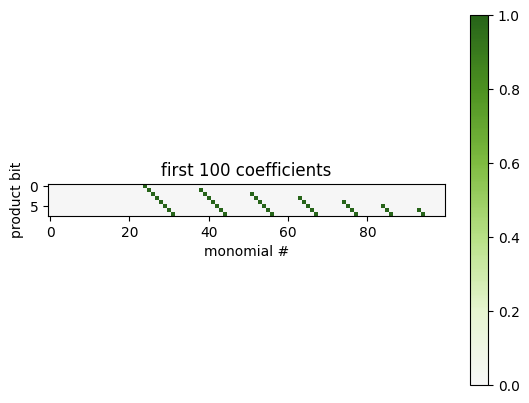

In [12]:
pltimshow(prod[:,:100])
plt.title('first 100 coefficients')
plt.ylabel('product bit')
plt.xlabel('monomial #')

## 17 * 11 = 187

In [13]:
variable_values = concat_ints_to_bin_list([17,11],8,'little')
variable_values

[1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]

In [14]:
product_binary = evaluate(prod, variable_values, basis)
product_binary

array([1, 1, 0, 1, 1, 1, 0, 1], dtype=object)

In [15]:
bin_list_to_ints(product_binary, 8, 'little')

[187]

# xoroshiro outputs, up to 3rd degree over 128 vars

In [16]:
# xoroshiro system
max_degree = 3
basis = MonomialBasis(128, max_degree=max_degree)
print(f"Basis size (degree ≤{max_degree} over 128 vars): {basis.size}")
S1_lo = initialize_variable_word(basis, 64)
S1_hi = initialize_variable_word(basis, 64, 64)
S1_is,S1_ca = add_words(S1_lo,S1_hi,basis)
S1_rotl = rotate_left(S1_is,17)
S1_out,S1_cb = add_words(S1_lo,S1_rotl,basis)
S2_hi = xor_words(S1_hi,S1_lo)
S2_lo = xor_words(xor_words(rotate_left(S1_lo,49),S2_hi),shift_left(S2_hi,21))
S2_hi = rotate_left(S2_hi,28)
S2_is,S2_ca = add_words(S2_lo,S2_hi,basis)
S2_rotl = rotate_left(S2_is,17)
S2_out,S2_cb = add_words(S2_lo,S2_rotl,basis)

Basis size (degree ≤3 over 128 vars): 349633


In [17]:
# order of all 64-bit words
blockorder = [
    'S1_lo',
    'S1_hi',
    'S1_ca',
    'S1_is',
    'S1_cb',
    'S1_out',
    'S2_lo',
    'S2_hi',
    'S2_ca',
    'S2_is',
    'S2_cb',
    'S2_out',
]

In [18]:
# lo, hi, 1st carry, intermediate sum, 2nd carry, output, for two states
polysystem = np.vstack([S1_lo,S1_hi,S1_ca,S1_is,S1_cb,S1_out,S2_lo,S2_hi,S2_ca,S2_is,S2_cb,S2_out])

Text(0.5, 0, 'monomial #')

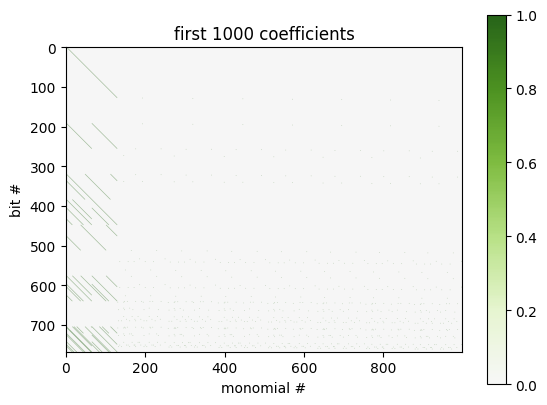

In [19]:
pltimshow(polysystem[:,:1000])
plt.title('first 1000 coefficients')
plt.ylabel('bit #')
plt.xlabel('monomial #')

In [20]:
lo = random.randint(-2**63, 2**63 - 1) & MASK64
hi = random.randint(-2**63, 2**63 - 1) & MASK64
out1A,out2A,nlA,nhA,is1,is2,hxl1,hxl2,ca1,cb1,ca2,cb2 = xoroshiro_extended(lo,hi)

In [21]:
state_vect = concat_ints_to_bin_list([lo,hi],64,'little')

In [22]:
true_data = np.array(concat_ints_to_bin_list([lo,hi,ca1,is1,cb1,out1A,nlA,nhA,ca2,is2,cb2,out2A],64,'little'))

In [23]:
degree_3_approximation = evaluate(polysystem, state_vect, basis).astype(float)

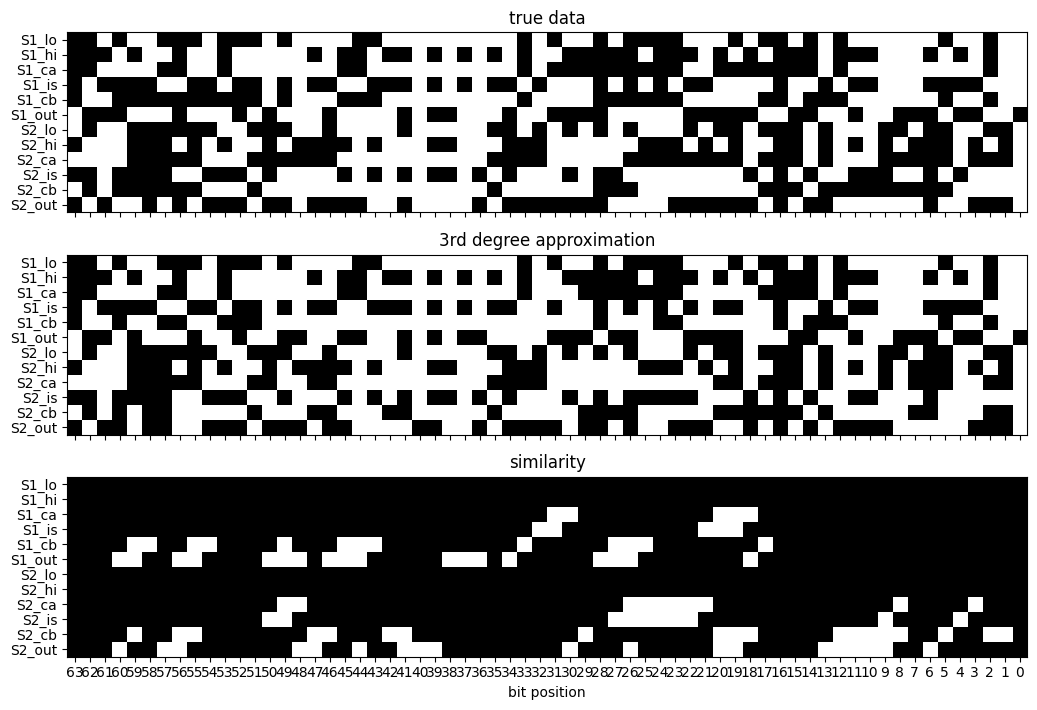

In [24]:
plot_stacked_arrays([
    true_data.reshape((-1,64))[:,::-1],
    degree_3_approximation.reshape((-1,64))[:,::-1],
    (true_data == degree_3_approximation).reshape((-1,64))[:,::-1],
],
                   row_labels=blockorder,
                   titles=[
                       'true data',
                       '3rd degree approximation',
                       'similarity',
                   ])